<a href="https://colab.research.google.com/github/rezajangara/rezajangara/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p dir="rtl" align="right">
<font size="+2" face="homa">
  <b>
تشخیص ماسک
  <br>
  <font size="+1" face="homa">
  </b>

<p dir="rtl" align="justify">
<font face="homa">
 ابتدا، با یک مثال عملی شبکه عصبی شروع می‌کنیم که از کتابخانه کراس پایتون برای یادگیری دسته‌بندی افراد با ماسک، بدون ماسک و ماسک نامناسب استفاده می‌کند. 

<br>
مسئله‌ای که می‌خواهیم در اینجا حل کنیم، دسته‌بندی تصاویر RGB   (۱۲۸×۱۲۸ پیکسل) به ۳ دسته (۰ تا ۲) است. ما از مجموعه ‌داده استفاده خواهیم کرد که تصاویر مربوط به دانشجویان دانشگاه شهید مدنی آذربایجان است. 
<br>
0: بدون ماسک
<br>
1: با ماسک
<br>
2: ماسک ناقص
<br>



<p dir="rtl" align="right">
<font size="+2" face="homa">
  <font size="+1" face="homa">


<p dir="rtl" align="justify">
<font face="homa">
<br>
هدف از این تمرین این است که شما الگوریتم داده شده را از چندین جهت مورد ارزیابی قرار دهید:
<br>
1. تعداد لایه های میانی
<br>
2. اندازه لایه ها یا همان تعداد نورون ها
<br>
3. تعداد تکرار یا همان تعداد اپک
<br>
4. اندازه دسته یا همان اندازه بچ
<br>
توجه داشته باشید که هدف ما این است که روی داده آزمایش به بهترین نتیجه برسیم نه روی داده آموزشی. 
<br>
به دانشجویی که بالاترین دقت را کسب کند نمره بالایی در نظر گرفته خواهد شد
<br>


In [54]:
import keras
keras.__version__

'2.9.0'

In [55]:
import numpy as np
import pandas as pd
import imageio
import random
import numpy as np
from PIL import Image
import os
from glob import glob
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from glob import glob
import matplotlib.pyplot as plt
import warnings

<p dir="rtl" align="justify">
<font face="homa">
خواندن داده از github و خارج کردن داده ها از حالت زیپ:
<br><br>


In [56]:
!wget https://raw.githubusercontent.com/rezajangara/rezajangara/main/Mask_detection_project.rar
!pip install unrar
!unrar x /content/Mask_detection_project.rar

--2022-11-22 21:40:47--  https://raw.githubusercontent.com/rezajangara/rezajangara/main/Mask_detection_project.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724983 (708K) [application/octet-stream]
Saving to: ‘Mask_detection_project.rar.3’

Mask_detection_proj 100%[===================>] 707.99K  --.-KB/s    in 0.007s  

2022-11-22 21:40:47 (101 MB/s) - ‘Mask_detection_project.rar.3’ saved [724983/724983]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Mask_detection_project.rar


Would you like to replace the existing file mask_detection_project/no_mask/n1.jpg
  2522 bytes, modified on 2020-05-22 02:49
with a

<p dir="rtl" align="justify">
<font face="homa">
ذخیره کردن مسیر هر تصویر از پوشه های مختلف:
<br><br>


In [57]:
from glob import glob
import os
image_no_mask_path = sorted(glob(os.path.join( "/content/mask_detection_project/no_mask/*")))
image_qualified_mask_path = sorted(glob(os.path.join( "/content/mask_detection_project/qualified_mask/*")))
image_unqualified_mask_path = sorted(glob(os.path.join( "/content/mask_detection_project/unqualified_mask/*")))

<p dir="rtl" align="justify">
<font face="homa">
تجمیع تمامی مسیرهای داده در و ذخیره در لیست data و مشخص کردن و ذخیره کردن لیبل ها در یک لیست:
<br><br>


In [58]:
import numpy as np
import imageio
data = []
labels = []

for i in image_no_mask_path:
  data.append(i)
  labels.append(0)

for i in image_qualified_mask_path:
  data.append(i)
  labels.append(1)

for i in image_unqualified_mask_path:
  data.append(i)
  labels.append(2)

In [59]:
image_paths = data
number_of_images, number_of_masks = len(data), len(labels)
print(f"There are {number_of_images} images in our dataset")

There are 248 images in our dataset


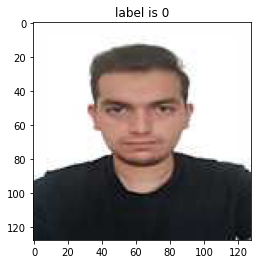

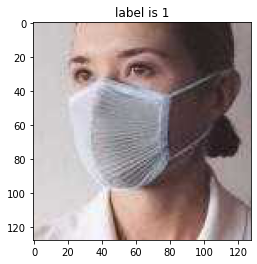

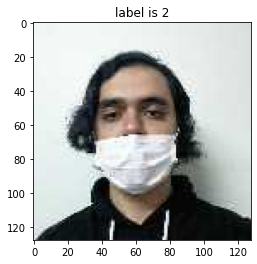

<Figure size 432x288 with 0 Axes>

In [60]:
import random
import matplotlib.pyplot as plt

number_of_samples = len(data)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)
    img = imageio.imread(data[N])
    plt.imshow(img)
    plt.title(f'label is {labels[N]}')
    plt.figure()

<p dir="rtl" align="justify">
<font face="homa">
جدا کردن 70 دصد کل داده ها به عنوان آموزش و 30 درصد به عنوان تست و بر زدن داده ها:
<br><br>


In [61]:
from sklearn.model_selection import train_test_split
# First split the image paths into training and validation sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(data, labels, train_size=0.70, random_state=42)

<p dir="rtl" align="justify">
<font face="homa">
خواندن یک به یک تصاویر و ذخیره در یک آرایه نامپای:
<br><br>


In [62]:
def read_image(image_path):
    data_resized= np.zeros([len(image_path), 128,  128, 3])
    n = 0
    for i in image_path:
        data_resized [n] = np.array(Image.open(i).resize((128,128)))
        n+=1
    return data_resized

<p dir="rtl" align="justify">
<font face="homa">
train_images و train_labels از مجموعه آموزشی، داده‌هایی هستند که مدل یاد خواهد گرفت. سپس، مدل با مجموعه آزمایش  test_images و test_labels مورد آزمایش قرار خواهد گرفت.
تصاویر به عنوان آرایه‌های نام‌پای کدگذاری می‌شوند و برچسب‌ها آرایه‌ا‌ی از ارقام هستند که دامنه‌شان از صفر تا دو است.
<br><br>
داده‌های آموزشی به شکل زیر می‌باشند:

In [63]:
train_images = read_image(train_image_paths)
test_images  = read_image(test_image_paths)

In [64]:
train_images.shape

(173, 128, 128, 3)

In [65]:
len(train_labels)

173

In [66]:
train_labels

[1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1]

<p dir="rtl" align="justify">
<font face="homa">
و داده‌های آزمایش بدین قرار هستند:

In [67]:
test_images.shape

(75, 128, 128, 3)

In [68]:
len(test_labels)

75

In [69]:
test_labels

[0,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]

<p dir="rtl" align="justify">
<font face="homa">
روند کار بدین شکل خواهد بود: ابتدا، داده‌های آموزشی را به عنوان ورودی به شبکه عصبی خواهیم داد؛ train_images و train_labels. سپس، شبکه ارتباط تصاویر و برچسب‌ها به همدیگر را یاد خواهد گرفت. نهایتاً، از شبکه خواهیم خواست تا پیش‌بینی‌هایی را برای test_images تولید کند و همخوانی یا عدم همخوانی این پیش‌بینی‌ها با برچسب‌های test_labels را بررسی خواهیم کرد.
<br><br>


In [70]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(128 * 128 * 3,)))
network.add(layers.Dense(3, activation='softmax'))


<p dir="rtl" align="justify">
<font face="homa">
اصلی‌ترین بلوک سازنده شبکه‌های عصبی، لایه است. لایه، عبارت است از ماژول پردازش داده‌ها که می‌توان آن‌ را فیلتر داده‌ها دانست. داده‌ها وارد شبکه شده و به شکل مناسب‌تری از آن خارج می‌شوند. بالأخص، لایه‌ها از داده‌های وارد شده بازنمایی‌ها  را استخراج می‌کنند (در بهترین حالت، بازنمایی‌هایی که برای مسئله موردنظر ما معنادارتر هستند). یادگیری عمیق عمدتاً شامل به هم پیوستن لایه‌های ساده‌ای است که نوعی عصاره‌گیری مرحله‌به‌مرحله  را اجرا خواهند کرد. مدل یادگیری عمیق شبیه یک غربال برای پردازش داده‌هاست، لایه‌ها به عنوان فیلترهای داده‌ای عمل می‌کنند که رفته‌رفته پالایش می‌شوند.
<br><br>
در اینجا، شبکه ما متشکل از دولایه متراکم  متوالی است، اتصال بین این لایه‌ها متراکم است و از این رو لایه‌های تمام متصل  نیز نامیده می‌شوند دومین (آخرین) لایه، یک‌لایه با 3-خروجی است که سافت‌مکس  نامیده می‌شود، یعنی آرایه‌ای با 3 امتیاز احتمال (که مجموعشان برابر یک است) را باز خواهد گرداند. هر امتیاز، عبارت از احتمالی خواهد بود که بیانگر احتمال تعلق تصویر مورد نظر به یکی از کلاس‌های 3 رقمی ما را نشان می‌دهد.
<br><br>
به‌منظور آماده کردن شبکه برای آموزش، باید سه مورد زیر را به عنوان بخشی از مرحله کامپایل  در نظر بگیریم:
<br>

<ul dir="rtl">
  <li>تابع هزینه: شبکه چگونه خواهد توانست عملکرد خود در مورد داده‌های آموزشی را ارزیابی نماید و بدین ترتیب چگونه خواهد توانست خودش را به مسیر درست هدایت کند.</li>
</ul>

<ul dir="rtl">
  <li>	بهینه‌ساز: مکانیسمی است که شبکه به ‌واسطه آن خود را به‌روز خواهد کرد. به‌روزرسانی بر مبنای تابع هزینه و داده‌هایی است که شبکه به عنوان ورودی دریافت می‌کند.</li>
</ul>

<ul dir="rtl">
  <li>	معیار‌هایی که در طول آموزش و آزمایش ثبت می‌شوند: در اینجا، تنها معیار دقت را مورد استفاده قرار می‌دهیم (تعداد تصاویری که به‌ درستی دسته‌بندی شده‌اند).</li>
</ul>

<p dir="rtl" align="justify">
<font face="Vazir">
هدف دقیق تابع هزینه و بهینه‌ساز در دو فصل بعدی کاملاً روشن خواهد شد.

In [71]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

<p dir="rtl" align="justify">
<font face="homa">
قبل از آموزش، داده‌ها پیش‌پردازش می‌شوند؛ یعنی شکل آن‌ها به صورتی تغییر داده می‌شود که شبکه انتظارش را دارد و نیز مقادیر آن به ‌گونه‌ای مقیاس بندی می‌شود که در بازه [0,1] قرار بگیرند. به عنوان مثال، تصاویر آموزشی ما قبلاً در آرایه‌ای به شکل (3, 128 ,128 ,62) و نوع unit8 و با مقادیری در بازه [0,255] ذخیره شده بودند. ما آن‌ها را به صورت آرایه float32 به شکل (3*128*128 ,62) با مقادیر بین 0 و 1 تبدیل می‌کنیم.

In [72]:
train_images = train_images.reshape((len(train_labels), 128 * 128 * 3))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((len(test_labels), 128 * 128 * 3))
test_images = test_images.astype('float32') / 255

<p dir="rtl" align="justify">
<font face="homa">
همچنین، باید برچسب‌ها را بر اساس دسته‌ای که به آن تعلق دارند کدگذاری کنیم؛ این گام را در فصل ۳ توضیح خواهیم داد.

In [73]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

<p dir="rtl" align="justify">
<font face="homa">
حال آماده آموزش شبکه هستیم. در کراس آموزش از طریق فراخوانی متد fit صورت می‌گیرد. ما مدل را براساس داده‌های آموزشی‌اش برازش  می‌کنیم:

In [74]:
network.fit(train_images, train_labels, epochs=150, batch_size=80)

Epoch 1/150
3/3 [==============================] - 0s 19ms/step - loss: 199.7238 - accuracy: 0.3815
Epoch 2/150
3/3 [==============================] - 0s 18ms/step - loss: 161.9335 - accuracy: 0.6532
Epoch 3/150
3/3 [==============================] - 0s 19ms/step - loss: 68.5471 - accuracy: 0.2717
Epoch 4/150
3/3 [==============================] - 0s 19ms/step - loss: 15.4707 - accuracy: 0.4682
Epoch 5/150
3/3 [==============================] - 0s 18ms/step - loss: 54.9778 - accuracy: 0.4277
Epoch 6/150
3/3 [==============================] - 0s 17ms/step - loss: 21.0715 - accuracy: 0.4220
Epoch 7/150
3/3 [==============================] - 0s 18ms/step - loss: 8.7982 - accuracy: 0.3988
Epoch 8/150
3/3 [==============================] - 0s 17ms/step - loss: 14.5739 - accuracy: 0.4335
Epoch 9/150
3/3 [==============================] - 0s 16ms/step - loss: 10.9094 - accuracy: 0.4509
Epoch 10/150
3/3 [==============================] - 0s 16ms/step - loss: 8.6665 - accuracy: 0.6474
Epoch 11/

<p dir="rtl" align="justify">
<font face="homa">
دو کمیت در طول آموزش نمایش داده می‌شوند: خطا و دقت شبکه روی داده‌های آموزشی. 
<br><br>
ما به‌ سرعت به دقت بالا در داده‌های آموزشی رسیدیم. اکنون اجازه دهید که مدل را در مجموعه آزمایش نیز بررسی کنیم:

In [75]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

3/3 [==============================] - 0s 5ms/step - loss: 0.8798 - accuracy: 0.6533


In [76]:
print('test_acc:', test_acc)

test_acc: 0.653333306312561


1/1 [==============================] - 0s 35ms/step


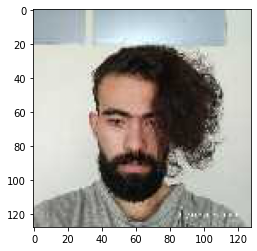

Lable: [1. 0. 0.]
Predicted Lable: [[0.34 0.33 0.33]]
1/1 [==============================] - 0s 17ms/step


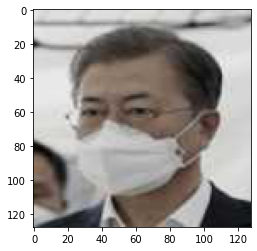

Lable: [0. 1. 0.]
Predicted Lable: [[0.32 0.36 0.33]]
1/1 [==============================] - 0s 14ms/step


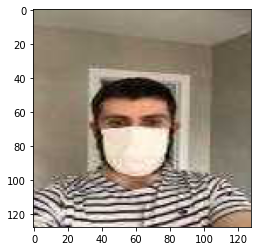

Lable: [0. 1. 0.]
Predicted Lable: [[0.1  0.84 0.06]]


In [77]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(3):
  img_inx = np.random.randint(0, len(test_images))

  pre = np.round(network.predict(test_images[img_inx:img_inx + 1]), 2)
  plt.imshow(np.reshape(test_images[img_inx], [128, 128, 3]))
  plt.show()
  print(f'Lable: {test_labels[img_inx]}')
  print(f'Predicted Lable: {pre}')

<p dir="rtl" align="justify">
<font face="homa">
میزان دقت مجموعه آزمایش خیلی کمتر از میزان دقت مجموعه آموزش است. این شکاف بین دقت آموزش و دقت آزمایش نمونه‌ای از بیش برازش است؛ یعنی گویای این واقعیت است که مدل‌های یادگیری ماشین روی ‌داده‌های جدید، نسبت به داده‌های آموزشی خودشان، عملکرد بدتری دارند. 
<br><br>
